# SBOM Vulnerability Analysis

**Note** For a detailed introduction to Software Bill Of Materials please click read [Intro to Software Bill Of Materials](./00-Intro-to-Software-Bill-Of-Materials.ipynb)

Software Bill of Materials (SBOM) contain details about the components and dependencies that make up a piece of software. This includes libraries, frameworks, modules, and more.  Loading SBOM files into a graph provides an efficent mechanism to explore common SBOM use cases such as Vulnerability Analysis.  Understanding dependencies allows teams to identify security vulnerabilities or licensing issues that may arise from open source or third-party code used in their software. Vulnerable dependencies are a major source of risk.  Dependency analysis provides visibility into all the direct and transitive dependencies used in a project. This allows security, legal, and development teams to gain a comprehensive inventory of the open source being utilized.

During development and maintenance, vulnerability analysis helps prevent components with known vulnerabilities from entering the software supply chain.  By knowing all components in use, security and development teams can cross-check them against vulnerability databases to see if any have known vulnerabilities or exposures. This allows proactively patching security flaws.

In summary, vulnerability analysis of SBOMs grants security and transparency into the software supply chain, allowing teams to efficiently mitigate risks introduced through use of third-party and open source components.


## Data Model

**Note** The data model being used has been covered in [Intro to Software Bill Of Materials](./00-Intro-to-Software-Bill-Of-Materials.ipynb) so please read that to get a deeper understanding of the summary presented below.

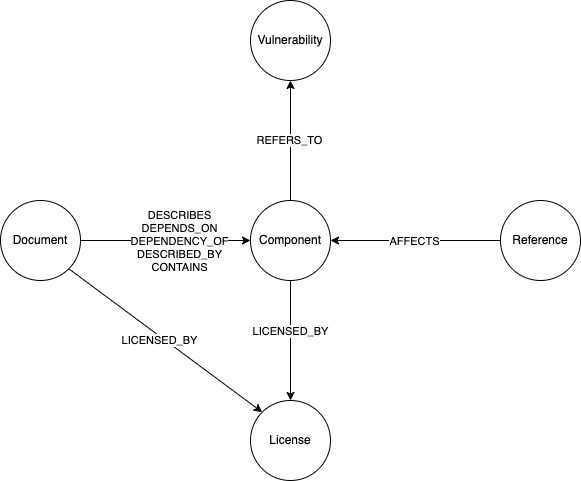

**Node Types**
* `Document` - This represents the SBOM document as well as the metadata associated with that SBOM.
* `Component` - This represents a specific component of a software system.
* `Reference` - This represents a reference to any external system which the system wanted to include as a reference.  This can range from package managers, URLs to external websites, etc.
* `Vulnerability` - This represents a specific known vulnerability for a component. 
* `License` - This represents a specific license associated for a component.

**Edge Types**
* `DESCRIBES`/`DEPENDS_ON`/`DEPENDENCY_OF`/`DESCRIBED_BY`/`CONTAINS` - This represents the type of relationship between a `Document` and a `Component` in the system. 
* `REFERS_TO` - This represents a reference between a `Component` and a `Reference`
* `AFFECTS` - This represents that a particular `Component` is affected by the connected `Vulnerability`

## Loading SBOM Data

In this notebook we will use [Nodestream](https://nodestream-proj.github.io/docs/) and the [Nodestream SBOM plugin](https://github.com/nodestream-proj/nodestream-plugin-sbom) to load several SPDX files which were sourced from Github using its SBOM feature, detailed [here](https://docs.github.com/en/rest/dependency-graph/sboms).  

Nodestream is a framework for dealing with semantically modeling data as a graph. It is designed to be flexible and extensible, allowing you to define how data is collected and modeled as a graph. It uses a pipeline-based approach to define how data is collected and processed, and it provides a way to define how the graph should be updated when the schema changes. All of this is done using a simple, human-readable configuration file in yaml format.

Let's begin by installing the required libraries for using Nodestream with Neptune and the SBOM plugin.

In [ ]:
!pip install -q pyyaml nodestream-plugin-neptune nodestream_plugin_sbom

The SBOM plugin enables users to import SBOM files in JSON formatted CycloneDX and SPDX into an opinionated graph data model in a graph database. Nodestream is a developer friendly Python framework for materializing and working with graph databases.

The included files for this notebook are:

* AWS CLI - version 2.0.6
* Gremlin Console - version 3.7.1
* Gremlin Server - version 3.7.1

For these example we have also provided CycloneDX based SBOMs as, unlike SPDX, they can optionally contain vulnerability information.

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  
If you would like to import your own SBOM files, this can be done by either saving them, in JSON format, to the `./example_sboms/02/` directory or by changing the directory location in the code below.
</details>
</div>

Running the cell below will setup our configuration file for loading our SBOM data.

In [ ]:
import json
from IPython.utils import io
from sbom_code import sbom_helper

# Retrieve the notebook configuration information to pass in as parameters and supress printing the config
with io.capture_output() as captured:
    mgc = get_ipython().run_line_magic
    mgc(magic_name = "graph_notebook_config", line="--store-to config")

# Create the nodestream.yaml file
sbom_helper.set_nodesteam_yaml(json.loads(config), "02/")

Running the code above will generate a `nodestream.yaml` file that specifies the source data and target, which in this case is our Neptune database or graph.

In [ ]:
!nodestream run sbom --target my-neptune

## Visualizing the Vulnerability Connections

Now that we have completed importing these SBOM files' lets begin by visualizing what the graph of vulnerabilities.

### Graph vulnerabilities and the components that they affect

In [ ]:
%%oc -d name

MATCH p=(v:Vulnerability)-[:AFFECTS]->(c) 
RETURN p

Now, let's take a look at the projects hierarchy.

### Graph of project hierarchy of these vulnerabilities


In [ ]:
%%oc -d name

MATCH p=(v:Vulnerability)-[:AFFECTS]->(c)<-[]-(:Document)
RETURN p

## Ranking projects to update

A common use case when looking at vulnerabilities is to analyze vulnerabilities and their dependencies to priortize projects to update based on the largest risk.  Priortizing the most risky projects allow development and security teams to better understand the security posture of the organization through identification of shared risks. 

### Find all `critical` and `high` risk vulnerabilities

In [ ]:
%%oc -d name

MATCH (v:Vulnerability)
WHERE v.`ratings.severity` in ['critical', 'high']
Return v.id, v.`ratings.severity` as severity, v.description
ORDER BY severity

Now that we know what the important vulnerabilities let's see how we can priortize these risks.  One way to priortize these risks is to find  projects where these vulnerabilities are shared.

### Finding Projects with Shared Vulnerabilties

In [ ]:
%%oc -d name

MATCH p=(v:Vulnerability)-[]->(c:Component)<-[:DESCRIBES]-(d:Document)
WHERE v.`ratings.severity` in ['critical', 'high']
WITH v, count(d) as document_count
WHERE document_count>1
MATCH p=(v:Vulnerability)-[]->(c:Component)<-[:DESCRIBES]-(d:Document)
RETURN p

Another way of looking at priortizing risks is to look at which vulnerability is impacting the most components

### Find the vulnerability impacting the most components

In [ ]:
%%oc -d name

MATCH (v:Vulnerability)-[]->(c:Component)<-[:DESCRIBES]-(d:Document)
WHERE v.`ratings.severity` in ['critical', 'high']
RETURN c.name as project,  v.`ratings.severity` as severity, count(v.`ratings.severity`) as vulnerability_cnt, d
ORDER BY project, severity, vulnerability_cnt DESC

A final way to look at priortizing risks is to look at which component has the most important vulnerabilities

### Find the component with the most critical or high severity vulnerabilities

In [ ]:
%%oc -d name

MATCH (v:Vulnerability)-[]->(c:Component)<-[:DESCRIBES]-(d:Document)
WHERE v.`ratings.severity` in ['critical', 'high']
WITH v, count(DISTINCT c.name) as cnt
RETURN v.id, v.`ratings.severity` as severity, cnt
ORDER BY cnt DESC, severity ASC

## Next Steps

In this notebook, we have demonstrated how to perform Vulnerabilit Analysis on SBOMs using Neptune Analytics.  If you are interested in the other types of SBOM analysis please look at the other notebooks available:

* [SBOM Dependency Analysis](./01-SBOM-Dependency-Analysis.ipynb)